# Analisi Comparativa Tecnologie BUL: Fibra Ottica e Wireless Access

- **Nome:** Melissa Selmanhaskaj
- **Ambiente utilizzato:** Anaconda3 python

## Introduzione

Il progetto Banda Ultra Larga (BUL) mira a fornire accesso ad Internet ad alta velocità a una vasta gamma di utenti e rappresenta così un fondamentale pilastro nell'evoluzione delle infrastrutture di connettività. 

Questo progetto Jupyter si concentra su due tecnologie chiavi: la Fibra Ottica (FTTH) e il Fixed Wireless Access (FWA) e il suo obbiettivo prinicpale è condurre un'analisi dettagliata dei dati relativi alla copertura, alla qualità del servizio e all'avanzamento dei lavori.


### Obbiettivo

Fornire una panoramica dello stato attuale del progetto BUL, con particolare attenzione alle tecnologie di connettività e ai lavori dei cantieri. 


# Introduzione del progetto

Importare le librerie necessarie per svolgere progetto e il DataFrame da un file '.csv'. 

## Glossario per lo stato dei cantieri
1. **In progettazione**
    - Il piano non è ancora stato emesso o è stato emesso ma il progetto del cantiere è ancora in progettazione.

2. **In esecuzione**
    - Il cantiere è in esecuzione.

3. **Terminato**
    - Il cantiere è chiuso e la fibra o è in collaudo per il test o è già stata collaudata, quindi funzionante.

4. **In funzione**
    - La fibra è in funzione con lavori terminati e collaudati.

In [1]:
import pandas as pd # manipolazione dati
import matplotlib.pyplot as plt # grafici
import numpy as np # operazioni numeriche
import folium # mappe interattive
import geopandas as gpd # gestione dati geografici
from IPython.display import display # visualizzare oggetti come mappe direttamente nel notebook

In [2]:
# Leggiamo il dataset CSV principale che contiene lo stato dei cantieri BUL
df = pd.read_csv('stato_lavori.csv', sep=';', encoding='UTF-8')

In [3]:
df.head()

,Regione,Provincia,Citta,Stato Fibra,Stato FWA,PCN_route,Nome sede PCN,Fibra,FWA,Piano fibra (anno),Piano FWA (anno)
0,Lombardia,Pavia,Pizzale,in esecuzione,in progettazione definitiva,POP_PV_34_LUNGAVILLA,Lungavilla,1,1,2023.0,2022.0
1,Friuli Venezia Giulia,Udine,Stregna,terminato,in progettazione definitiva,NaN,NaN,1,1,2022.0,2021.0
2,Sicilia,Caltanissetta,Butera,in progettazione esecutiva,in progettazione definitiva,POP_CL_02_GELA,Gela,1,1,2022.0,2022.0
3,Piemonte,Novara,Romagnano Sesia,in progettazione esecutiva,in progettazione definitiva,POP_NO_02_GHEMME,Ghemme,1,1,2022.0,2022.0
4,Toscana,Firenze,Certaldo,terminato,in progettazione esecutiva,POP_FI_16_CERTALDO,Certaldo,1,1,2019.0,2021.0


In [4]:
# Dato che voglio portare la colonna 'Piano fibra (anno)' e 'Piano FWA (anno)' da float64 a int64, che riempire l'na come 0 per evitare errori nella riga dopo
df['Piano fibra (anno)'] = df['Piano fibra (anno)'].fillna(0)
df['Piano FWA (anno)'] = df['Piano FWA (anno)'].fillna(0)

In [5]:
# Convertiamo le colonne da float64 a int64
# Gli anni devono essere interi, non decimali
df['Piano fibra (anno)'] = df['Piano fibra (anno)'].astype('int64')
df['Piano FWA (anno)'] = df['Piano FWA (anno)'].astype('int64')

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7708 entries, 0 to 7707
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   Regione             7708 non-null   object
 1   Provincia           7708 non-null   object
 2   Citta               7707 non-null   object
 3   Stato Fibra         7438 non-null   object
 4   Stato FWA           7665 non-null   object
 5   PCN_route           5564 non-null   object
 6   Nome sede PCN       5564 non-null   object
 7   Fibra               7708 non-null   int64 
 8   FWA                 7708 non-null   int64 
 9   Piano fibra (anno)  7708 non-null   int64 
 10  Piano FWA (anno)    7708 non-null   int64 
dtypes: int64(4), object(7)
memory usage: 662.5+ KB


In [7]:
# Creo le stringhe per filtrare i lavori in base al loro stato, come specificato nel glossario
str_prog = 'in programmazione|in progettazione' # In progettazione
str_esec = 'in esecuzione' # In esecuzione
str_term = 'terminato|lavori chiusi|in collaudo' # Terminato

# Analisi generale del DataFrame

Il primo grafico consente di analizzare i cantieri in base ai 3 stati: "Terminato", "In esecuzione", "In progettazione" della Fibra FTTH divisi per ogni piano d'anno.
Non è quindi normale che nel 2019 o 2020 non ci siano cantieri in esecuzione o in programmazione.

- **Piano d'anno**, che si riferisce alla colonna 'Piano x (anno)' ('x' a seconda della tecnologia), è quando è stato emesso, nello specifico in quale anno, il programma per quel cantiere e quindi anche il possibile inizio del cantiere.
Nella mia analisi ho deciso di togliere il 'possibile', e quindi di eguagliare l'anno di emissione del piano come l'anno di inizio dei lavori.

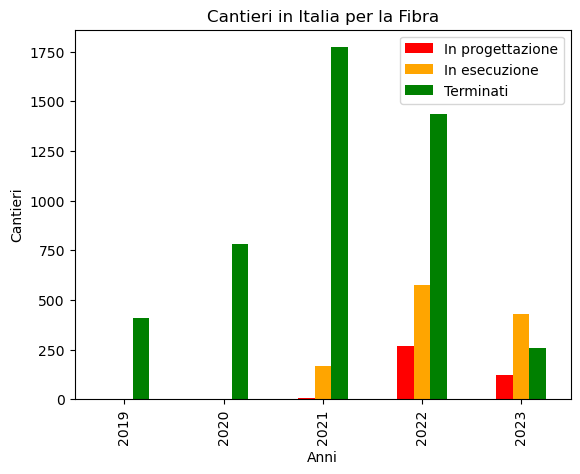

In [8]:
# Filtriamo i cantieri Fibra per stato e contiamo quanti ce ne sono per anno del piano
# Cantieri terminati
terminati = df[(df['Stato Fibra'].str.contains(str_term, na=False)) & (df['Fibra'] != 0)]['Piano fibra (anno)'].value_counts().sort_index() # sort index gli ordina cronologicamente
# Cantieri in esecuzione
in_esecuzione = df[(df['Stato Fibra'].str.contains(str_esec, na=False)) & (df['Fibra'] != 0)]['Piano fibra (anno)'].value_counts().sort_index()
# Cantieri in progettazione 
in_progettazione = df[(df['Stato Fibra'].str.contains(str_prog, na=False)) & (df['Fibra'] != 0)]['Piano fibra (anno)'].value_counts().sort_index()

# Combiniamo i dati in un DataFrame per avere tutte le informazioni insieme
conteggio_combinato_lavori_lomb = pd.DataFrame({'In progettazione': in_progettazione, 'In esecuzione': in_esecuzione, 'Terminati': terminati})

# Creiamo un grafico a barre per visualizzare i cantieri per anno e stato
conteggio_combinato_lavori_lomb.plot(kind='bar', color=['red', 'orange', 'green'])
plt.title("Cantieri in Italia per la Fibra")
plt.xlabel('Anni')
plt.ylabel('Cantieri')
plt.show()

Ora analizzeremo in tutta Italia dove è presente la Fibra FTTH e la Fibra FWA.

1-1: 5958, 0-1: 1484, 0-0: 266


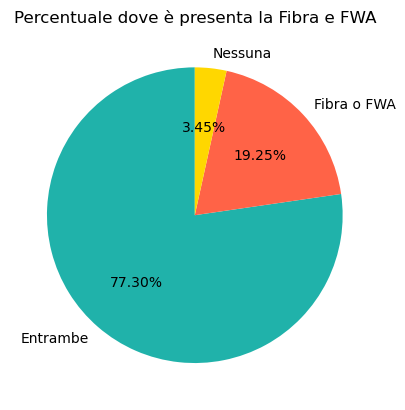

In [9]:
# Contiamo le città in base alla presenza di Fibra e FWA

# Città con entrambe le tecnologie (Fibra=1 e FWA=1)
c1_1 = df[(df['Fibra'] == 1) & (df['FWA'] == 1)].shape[0]

# Città con almeno una delle due tecnologie (Fibra=1 o FWA=1) ma non entrambe
c0_1 = df[(df['Fibra'] == 1) | (df['FWA'] == 1)].shape[0] - c1_1 

# Città senza nessuna tecnologia (Fibra=0 e FWA=0)
c0_0 = df[(df['Fibra'] == 0) & (df['FWA'] == 0)].shape[0]
print(f"1-1: {c1_1}, 0-1: {c0_1}, 0-0: {c0_0}")

# Creiamo una serie per il grafico a torta
totale = pd.Series([c1_1, c0_1, c0_0], index=['Entrambe', 'Fibra o FWA', 'Nessuna'])

# Creiamo il grafico a torta per visualizzare la percentuale di città con Fibra e/o FWA
totale.plot(kind='pie', autopct='%1.2f%%', startangle=90, colors=['#20B2AA', '#FF6347', 'gold'])

plt.title("Percentuale dove è presenta la Fibra e FWA")
#plt.legend()
plt.show()

Analizzando la fetta arancione (19,25%) possiamo vedere chi prevale tra le due:

In [10]:
# Contiamo le città con solo Fibra (Fibra=1, FWA=0)
fibra = df[(df['Fibra'] == 1) & (df['FWA'] == 0)].shape[0]

# Contiamo le città con solo FWA (Fibra=0, FWA=1)
fwa = df[(df['Fibra'] == 0) & (df['FWA'] == 1)].shape[0]

print(f"I dati che abbiamo: Fibra = {fibra}, FWA = {fwa}")

# Confrontiamo quale tecnologia è più diffusa tra quelle presenti singolarmente
if(fibra > fwa):
    print("La fibra è in numero maggiore!")
else:
    print("La FWA è in numero maggiore!")


I dati che abbiamo: Fibra = 274, FWA = 1210
La FWA è in numero maggiore!


Ecco le regioni nello specifico, con il numero di cantieri, dove è disponibile solo FWA.

In [11]:
# Seleziono le città dove è presente solo la FWA (Fibra=0 e FWA=1)
# e raggruppo per Regione per contare quante città per ciascuna regione
tot_fwa_per_regione = df.loc[(df['Fibra'] == 0) & (df['FWA'] == 1), ['Regione']].groupby(by=['Regione']).size()
print("Le regioni dove è presente solo la FWA")
# Creiamo un DataFrame con i totali e ordiniamo le regioni in ordine decrescente
# di numero di città con solo FWA
regioni_fwa = pd.DataFrame({'FWA': tot_fwa_per_regione}).sort_values(by='FWA', ascending=False) # avrei potuto usare df[(df['Fibra'] == 0) & (df['FWA'] == 1)]['Regione'].value_counts()
print(regioni_fwa)

Le regioni dove è presente solo la FWA
                            FWA
Regione                        
Lombardia                   292
Sardegna                    175
Calabria                    156
Veneto                      105
Emilia Romagna               96
Piemonte                     83
Campania                     79
Toscana                      44
Puglia                       32
Lazio                        31
Liguria                      30
Friuli Venezia Giulia        26
Marche                       14
Abruzzo                      13
Umbria                       12
Basilicata                    9
Sicilia                       9
Valle d'Aosta                 3
Trentino Alto Adige-Trento    1


Ora Visoniamo per Regione il numero di cantieri aperti e non per la Fibra e FWA.

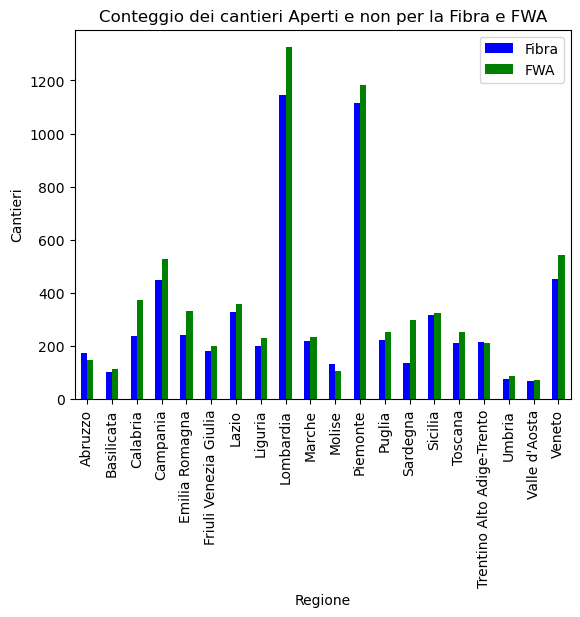

In [12]:
# Contiamo il numero di cantieri per regione per ogni tecnologia

# Cantieri con Fibra presente (Fibra=1) raggruppati per Regione
fibra_cablata = df[df['Fibra'] == 1]['Regione'].value_counts() # df.loc[df['Fibra'] == 1, ['Regione', 'Fibra']].groupby(by='Regione').sum()# Alternativa: usare groupby e sum sulle colonne  df.loc[df['Fibra'] == 1, ['Regione', 'Fibra']].groupby(by='Regione').sum()

# Cantieri con FWA presente (FWA=1) raggruppati per Regione
fwa = df[df['FWA'] == 1]['Regione'].value_counts()

# Combiniamo i due conteggi in un unico DataFrame per confronto
conteggio_combinato = pd.DataFrame({'Fibra': fibra_cablata, 'FWA': fwa})

# Creiamo un grafico a barre per visualizzare il numero di cantieri per Regione
conteggio_combinato.plot(kind='bar', color=['blue', 'green'])
plt.title("Conteggio dei cantieri Aperti e non per la Fibra e FWA")
plt.xlabel('Regione')
plt.ylabel('Cantieri')
plt.show()

Ora vediamo i lavori terminati.

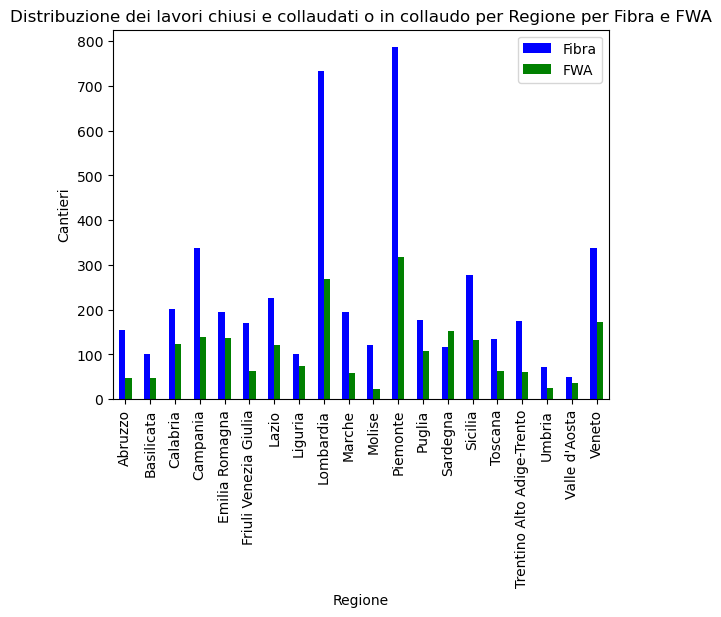

In [13]:
# Contiamo i cantieri terminati per Regione per entrambe le tecnologie

# Cantieri Fibra terminati (terminato, lavori chiusi o in collaudo)
fibra_cablata = df[df['Stato Fibra'].str.contains(str_term, na=False)]['Regione'].value_counts() 
# Cantieri FWA terminati (terminato, lavori chiusi o in collaudo)
fwa = df[df['Stato FWA'].str.contains(str_term, na=False)]['Regione'].value_counts()

# Combiniamo i due conteggi in un unico DataFrame
conteggio_combinato_lavori = pd.DataFrame({'Fibra': fibra_cablata, 'FWA': fwa})

# Creiamo un grafico a barre per visualizzare i cantieri terminati per Regione
conteggio_combinato_lavori.plot(kind='bar', color=['blue', 'green'])
plt.title('Distribuzione dei lavori chiusi e collaudati o in collaudo per Regione per Fibra e FWA')
plt.xlabel('Regione')
plt.ylabel('Cantieri')
plt.show()

Ora i lavori in progettazione.

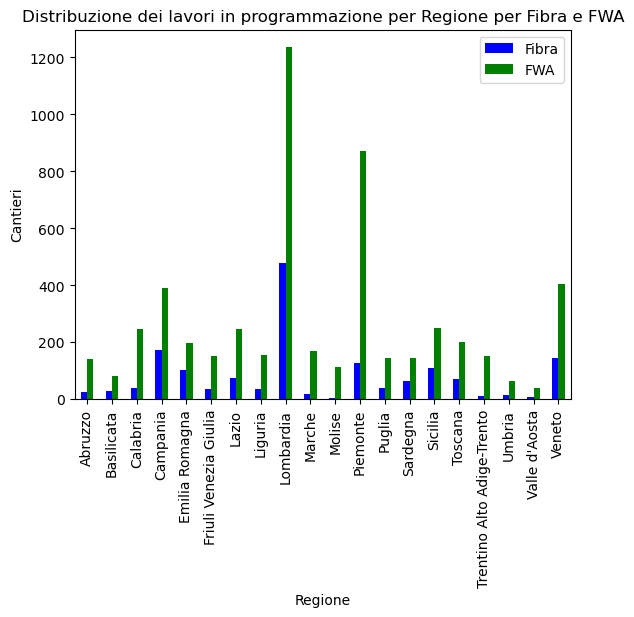

In [14]:
# Contiamo i cantieri in progettazione per Regione per entrambe le tecnologie

# Cantieri Fibra in progettazione (in programmazione o in progettazione)
fibra_cablata = df[df['Stato Fibra'].str.contains(str_prog, na=False)]['Regione'].value_counts() 
# Cantieri FWA in progettazione (in programmazione o in progettazione)
fwa = df[df['Stato FWA'].str.contains(str_prog, na=False)]['Regione'].value_counts()

# Combiniamo i due conteggi in un unico DataFrame
conteggio_combinato_lavori = pd.DataFrame({'Fibra': fibra_cablata, 'FWA': fwa})

# Creiamo un grafico a barre per visualizzare i cantieri in progettazione per Regione
conteggio_combinato_lavori.plot(kind='bar', color=['blue', 'green'])
plt.title('Distribuzione dei lavori in programmazione per Regione per Fibra e FWA')
plt.xlabel('Regione')
plt.ylabel('Cantieri')
plt.show()

Analizzando i cantieri chiusi o collaudati e non è possibile notare una grande diminuzione per quanto riguarda la FWA, al contrario la FWA rimane stabile, rispetto al primo grafico, che mostrava tutti i cantieri aperti e non. 

Possiamo inoltre nnotare con il terzo grafico che i lavori relativi alla FWA sono in ritardo rispetto alla Fibra classica cablata FTTH.

Nei seguenti grafici ho iniziato a notare che alla Lombardia sarebbe carino prestare più attenzione...in seguito l'analizzero meglio.

Ora analizziamo l'andamento della Fibra e della FWA divisi per piani d'anno.

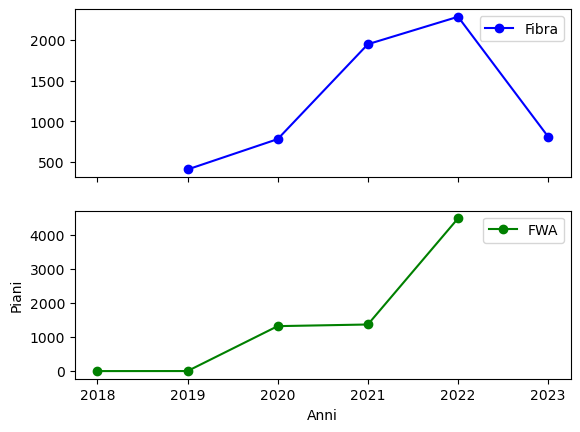

In [15]:
# Contiamo il numero di cantieri per anno di piano per Fibra e FWA
# Solo per i cantieri attivi (Fibra=1 o FWA=1) e con anno diverso da 0
valori_fibra = df[(df['Fibra'] == 1) & (df['Piano fibra (anno)'] != 0)]['Piano fibra (anno)'].value_counts().sort_index()
valori_fwa = df[(df['FWA'] == 1) & (df['Piano FWA (anno)'] != 0)]['Piano FWA (anno)'].value_counts().sort_index()

# Combiniamo i dati in un DataFrame per confronto
valori_df = pd.DataFrame({'Fibra': valori_fibra, 'FWA': valori_fwa})

# Creiamo grafici a linee con marker per visualizzare l'andamento dei piani per anno
# Un subplot per ciascuna tecnologia
valori_df.plot(marker='o', color=['blue', 'green'], subplots=True)

# Etichette per gli assi
plt.xlabel('Anni')
plt.ylabel('Piani')
df['Piano FWA (anno)']

# Creiamo un DataFrame solo per Fibra per calcolare incrementi successivamente
df_incr = pd.DataFrame({'Valori': valori_fibra})

Calcoliamo l'incremento percentuale della Fibra, dato che è quella con l'andamento più 'bizzarro'. 
Qui possiamo notare numeri più grandi poiché precedentemente la suddivisione avveniva per regione al contrario qui è per anni. 

In [16]:
# Impostiamo l'incremento percentuale del primo anno (2019) a NaN, 
# perché non possiamo calcolare un incremento senza anno precedente
df_incr.loc[2019, 'Incremento %'] = np.nan

# Ciclo sugli anni successivi per calcolare l'incremento percentuale anno su anno
for i in range(2020, 2024):
     # Incremento % = (Valore anno corrente - Valore anno precedente) / Valore anno precedente * 100
    nuovo_valore = ((df_incr.loc[i,'Valori'] - df_incr.loc[i-1,'Valori'])/df_incr.loc[i-1,'Valori']) * 100 
    df_incr.loc[i,'Incremento %'] = nuovo_valore
    # Visualizziamo il DataFrame con i valori e l'incremento percentuale
df_incr

,Valori,Incremento %
Piano fibra (anno),,
2019,409,NaN
2020,782,91.198044
2021,1947,148.976982
2022,2284,17.308680
2023,810,-64.535902


# Analisi per una regione Specifica
- La Lombardia

Ho deciso di importare il DataFrame di tutti i comuni italini e di farlo filtrare per le città interessate dal progetto BUL.

In [17]:
df_geo = pd.read_csv('italy_geo.csv', sep=';', encoding='UTF-8')
df_geo.info()
df_geo_citta = df_geo.copy()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7978 entries, 0 to 7977
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   istat   7978 non-null   int64  
 1   comune  7977 non-null   object 
 2   lng     7978 non-null   float64
 3   lat     7978 non-null   float64
dtypes: float64(2), int64(1), object(1)
memory usage: 249.4+ KB


In [18]:
# Filtriamo il DataFrame dei comuni per includere solo quelli presenti nel dataset principale BUL
# .isin() verifica se ciascun comune è presente nella lista delle città del progetto
df_geo_citta_filter = df_geo_citta['comune'].isin(df['Citta'].unique())

# Applichiamo il filtro e manteniamo solo i comuni interessati dal progetto BUL
df_geo_citta = df_geo_citta[df_geo_citta_filter]


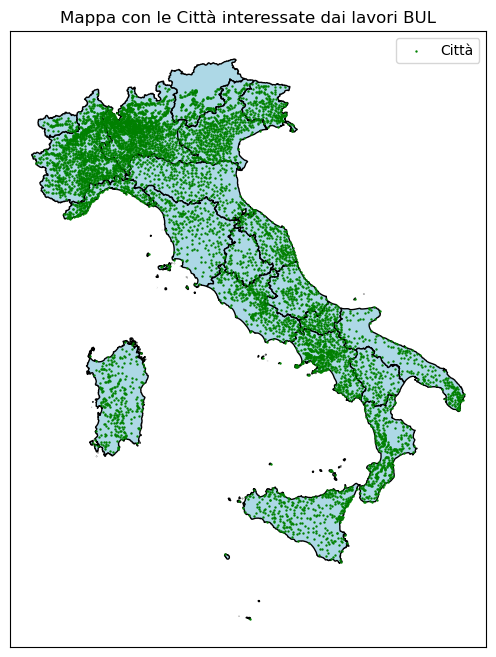

In [19]:
# Definiamo il sistema di coordinate (CRS) standard per lat/lon
crs_italy = 'EPSG:4326'

# Creiamo geometrie punti dai dati di latitudine e longitudine
geometry = gpd.points_from_xy(df_geo_citta['lng'], df_geo_citta['lat'])

# Creiamo un GeoDataFrame con le geometrie dei comuni coinvolti nel progetto BUL
gdf_citta = gpd.GeoDataFrame(df_geo_citta, geometry=geometry, crs=crs_italy)

# Importiamo il GeoJSON delle regioni italiane per avere i confini geografici
url_italy = "https://raw.githubusercontent.com/openpolis/geojson-italy/master/geojson/limits_IT_regions.geojson"
italian_regions = gpd.read_file(url_italy)

# Plottiamo le regioni italiane
ax = italian_regions.plot(figsize=(10, 8), color='lightblue', edgecolor='black')

# Plottiamo i comuni coinvolti nel progetto BUL sopra la mappa delle regioni
gdf_citta.plot(ax=ax, color='green', markersize=0.5, marker='o', label='Città')

# Rimuoviamo i numeri sugli assi per chiarezza
ax.set_xticks([])
ax.set_yticks([])

# Titolo e legenda
plt.title('Mappa con le Città interessate dai lavori BUL')
plt.legend()
plt.show()


Notiamo dalla figura che La Lombardia è la regione con più citta interessate.

In [20]:
# Filtriamo il dataset principale per analizzare solo i cantieri nella regione Lombardia
df_lomb = df[df['Regione'] == 'Lombardia']
df_lomb.info()
df_lomb.head()

<class 'pandas.core.frame.DataFrame'>
Index: 1516 entries, 0 to 7703
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   Regione             1516 non-null   object
 1   Provincia           1516 non-null   object
 2   Citta               1516 non-null   object
 3   Stato Fibra         1516 non-null   object
 4   Stato FWA           1513 non-null   object
 5   PCN_route           1170 non-null   object
 6   Nome sede PCN       1170 non-null   object
 7   Fibra               1516 non-null   int64 
 8   FWA                 1516 non-null   int64 
 9   Piano fibra (anno)  1516 non-null   int64 
 10  Piano FWA (anno)    1516 non-null   int64 
dtypes: int64(4), object(7)
memory usage: 142.1+ KB


,Regione,Provincia,Citta,Stato Fibra,Stato FWA,PCN_route,Nome sede PCN,Fibra,FWA,Piano fibra (anno),Piano FWA (anno)
0,Lombardia,Pavia,Pizzale,in esecuzione,in progettazione definitiva,POP_PV_34_LUNGAVILLA,Lungavilla,1,1,2023,2022
5,Lombardia,Cremona,Rivarolo del Re ed Uniti,in esecuzione,in progettazione definitiva,POP_MN_02_COMMESSAGGIO,Commessaggio,1,1,2023,2022
8,Lombardia,Milano,Trezzano sul Naviglio,in programmazione,in programmazione,NaN,NaN,0,0,0,0
16,Lombardia,Pavia,Pieve Albignola,in collaudo,terminato,POP_PV_37_PIEVE_ALBIGNOLA,Pieve Albignola,1,1,2021,2020
21,Lombardia,Brescia,Verolanuova,in esecuzione,in collaudo,POP_BS_02_VEROLANUOVA,Verolanuova,1,1,2022,2020


Andiamo ad analizzare i cantieri per la FWA.

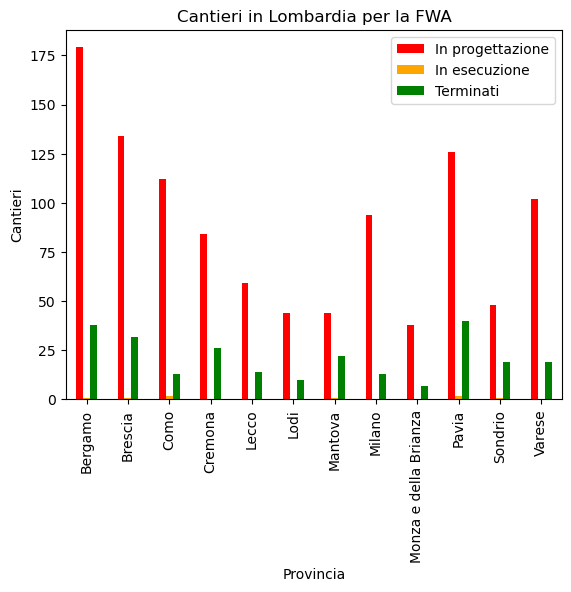

In [21]:
# Filtriamo i cantieri FWA in Lombardia per stato
# 'Terminati' = cantieri completati o in collaudo
terminati = df_lomb[(df_lomb['Stato FWA'].str.contains(str_term, na=False)) & (df_lomb['FWA'] != 0)]['Provincia'].value_counts().sort_index()

# 'In esecuzione' = cantieri attualmente attivi
in_esecuzione = df_lomb[(df_lomb['Stato FWA'].str.contains(str_esec, na=False)) & (df_lomb['FWA'] != 0)]['Provincia'].value_counts().sort_index()

# 'In progettazione' = cantieri pianificati ma non ancora iniziati
in_progettazione = df_lomb[(df_lomb['Stato FWA'].str.contains(str_prog, na=False)) & (df_lomb['FWA'] != 0)]['Provincia'].value_counts().sort_index()

# Creiamo un DataFrame combinato per facilitare la visualizzazione
conteggio_combinato_lavori_lomb = pd.DataFrame({
    'In progettazione': in_progettazione,
    'In esecuzione': in_esecuzione,
    'Terminati': terminati
})

# Visualizziamo i dati con un grafico a barre
conteggio_combinato_lavori_lomb.plot(kind='bar', color=['red', 'orange', 'green'])
plt.title("Cantieri in Lombardia per la FWA")
plt.xlabel('Provincia')
plt.ylabel('Cantieri')
plt.show()


Ora vediamo i Cantieri divisi per piano d'anno.

Il totale dei piani è: 1325


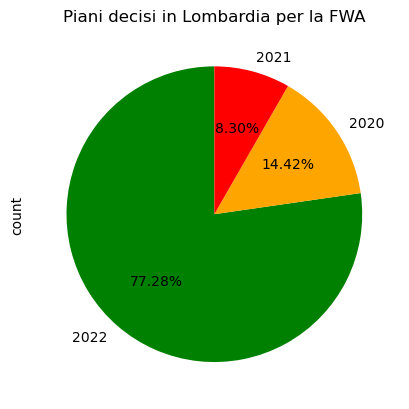

In [22]:
# Contiamo il numero di cantieri FWA per anno del piano nella regione Lombardia
totale = df_lomb[df_lomb['FWA'] == 1]['Piano FWA (anno)'].value_counts()

# Creiamo un grafico a torta per visualizzare la distribuzione dei piani per anno
totale.plot(
    kind='pie',             # tipo di grafico
    autopct='%1.2f%%',      # percentuale sul totale
    startangle=90,          # angolo di partenza del grafico
    colors=['green', 'orange', 'red']  # colori personalizzati
)

# Titolo del grafico
plt.title("Piani decisi in Lombardia per la FWA")

# Stampo il totale dei piani per avere un riferimento numerico
print("Il totale dei piani è:", totale.sum())

# Mostriamo il grafico
plt.show()


Nel 2022 c'è stato un grande aumento del numero di piani.

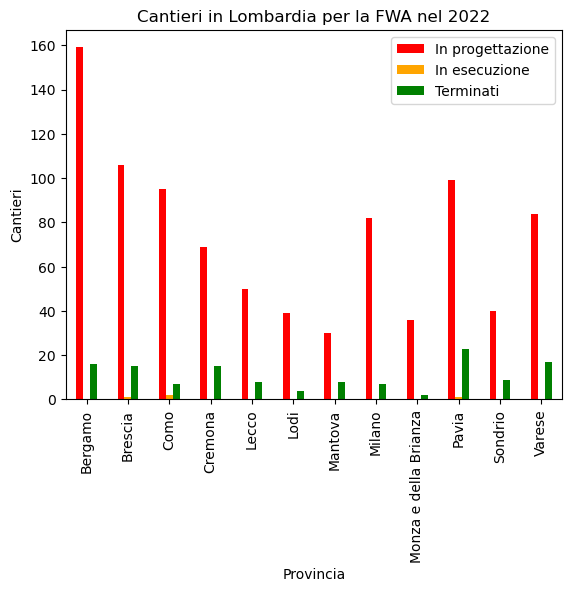

In [23]:
# Filtriamo i cantieri FWA in Lombardia per l'anno del piano 2022 e per stato

# Cantieri terminati o in collaudo nel 2022
terminati = df_lomb[
    (df_lomb['Stato FWA'].str.contains(str_term, na=False)) &
    (df_lomb['Piano FWA (anno)'] == 2022)
]['Provincia'].value_counts()

# Cantieri in esecuzione nel 2022
in_esecuzione = df_lomb[
    (df_lomb['Stato FWA'].str.contains(str_esec, na=False)) &
    (df_lomb['Piano FWA (anno)'] == 2022)
]['Provincia'].value_counts()

# Cantieri in progettazione nel 2022
in_progettazione = df_lomb[
    (df_lomb['Stato FWA'].str.contains(str_prog, na=False)) &
    (df_lomb['Piano FWA (anno)'] == 2022)
]['Provincia'].value_counts()

# Creiamo un DataFrame combinato per la visualizzazione
conteggio_combinato_lavori_lomb = pd.DataFrame({
    'In progettazione': in_progettazione,
    'In esecuzione': in_esecuzione,
    'Terminati': terminati
})

# Visualizziamo i dati con un grafico a barre
conteggio_combinato_lavori_lomb.plot(kind='bar', color=['red', 'orange', 'green'])
plt.title("Cantieri in Lombardia per la FWA nel 2022")  # Correzione: Piemonte -> Lombardia
plt.xlabel('Provincia')
plt.ylabel('Cantieri')
plt.show()


Sopratutto grazie al grafico a torta, possiamo notare che anche se abbiamo analizzato un solo anno, questo è effettivamente quello con più cantieri, indipendentmente se sono chiusi, aperti o in progettazione.

Ora vediamo lo stato della Fibra nel 2022 in Lombardia, di modo tale di confrontarle con il grafico FWA sopra.

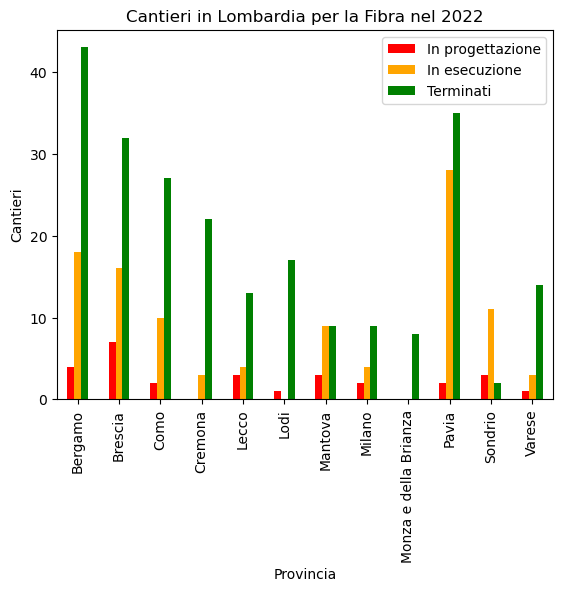

In [24]:
# Filtriamo i cantieri Fibra (FTTH) in Lombardia per l'anno del piano 2022 e per stato

# Cantieri terminati o in collaudo nel 2022
terminati = df_lomb[
    (df_lomb['Stato Fibra'].str.contains(str_term, na=False)) &
    (df_lomb['Piano fibra (anno)'] == 2022)
]['Provincia'].value_counts()

# Cantieri in esecuzione nel 2022
in_esecuzione = df_lomb[
    (df_lomb['Stato Fibra'].str.contains(str_esec, na=False)) &
    (df_lomb['Piano fibra (anno)'] == 2022)
]['Provincia'].value_counts()

# Cantieri in progettazione nel 2022
in_progettazione = df_lomb[
    (df_lomb['Stato Fibra'].str.contains(str_prog, na=False)) &
    (df_lomb['Piano fibra (anno)'] == 2022)
]['Provincia'].value_counts()

# Creiamo un DataFrame combinato per la visualizzazione dei dati
conteggio_combinato_lavori_lomb = pd.DataFrame({
    'In progettazione': in_progettazione,
    'In esecuzione': in_esecuzione,
    'Terminati': terminati
})

# Visualizziamo i cantieri con un grafico a barre
conteggio_combinato_lavori_lomb.plot(kind='bar', color=['red', 'orange', 'green'])
plt.title("Cantieri in Lombardia per la Fibra nel 2022")
plt.xlabel('Provincia')
plt.ylabel('Cantieri')
plt.show()


Notiamo anche qua che il lavoro della Fibra è molto più avanti rispetto a quello della FWA.

# Riferimento per PCN
- Importo un DataFrame dei PCN, per visionare tutti i PCN del progetto BUL.

In [25]:
# Leggiamo il dataset dei PCN (Punti di Connettività Nazionali)
df_pcn = pd.read_csv('pcn_route.csv', sep=';', encoding='UTF-8')

# Sostituiamo la virgola con il punto per i valori decimali di longitudine e latitudine
df_pcn['Longitudine'] = df_pcn['Longitudine'].str.replace(',', '.')
df_pcn['Latitudine'] = df_pcn['Latitudine'].str.replace(',', '.')

# Convertiamo le colonne Longitudine e Latitudine in valori numerici (float)
df_pcn['Longitudine'] = pd.to_numeric(df_pcn['Longitudine'])
df_pcn['Latitudine'] = pd.to_numeric(df_pcn['Latitudine'])


In [26]:
df_pcn.info()
df_pcn.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 612 entries, 0 to 611
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Regione      612 non-null    object 
 1   Provincia    612 non-null    object 
 2   Comune       612 non-null    object 
 3   Nome PCN     612 non-null    object 
 4   Latitudine   612 non-null    float64
 5   Longitudine  612 non-null    float64
dtypes: float64(2), object(4)
memory usage: 28.8+ KB


,Regione,Provincia,Comune,Nome PCN,Latitudine,Longitudine
0,Abruzzo,Chieti,COLLEDIMEZZO,POP_CH_13_COLLEDIMEZZO,41.986148,14.385157
1,Abruzzo,Chieti,CASOLI,POP_CH_02_CASOLI,42.124997,14.298431
2,Abruzzo,Chieti,ATESSA,POP_CH_04_ATESSA,42.068806,14.457222
3,Abruzzo,Chieti,CASTELGUIDONE,POP_CH_05_CASTELGUIDONE,41.818470,14.523160
4,Abruzzo,Chieti,GUARDIAGRELE,POP_CH_06_GUARDIAGRELE,42.187554,14.212727


In [27]:
# Filtriamo i PCN presenti nel dataset principale dei cantieri BUL
# Questo serve a considerare solo i PCN effettivamente rilevanti per il nostro progetto
df_pcn_filtered = df_pcn['Nome PCN'].isin(df['PCN_route'].unique())

# Creiamo un nuovo DataFrame con i PCN filtrati
df_pcn_2 = df_pcn[df_pcn_filtered]


In [28]:
# Creo una mappa centrata sulla media delle coordinate dei PCN filtrati
mappa2 = folium.Map(location=[df_pcn_2['Latitudine'].mean(), df_pcn_2['Longitudine'].mean()], zoom_start=7)

# Aggiungo un CircleMarker per ogni PCN nel DataFrame filtrato
for index, row in df_pcn_2.iterrows():
    folium.CircleMarker(
        location=[row['Latitudine'], row['Longitudine']],  # Posizione del marker
        radius=3,                                        # Dimensione del cerchio
        color='blue',                                   # Colore bordo
        fill=True,                                      # Riempimento attivo
        fill_color='blue',                              # Colore riempimento
        fill_opacity=0.6,                               # Opacità del riempimento
        popup=f"PCN: {row['Nome PCN']}"                # Etichetta popup con il nome del PCN
    ).add_to(mappa2)

# Visualizzo la mappa interattiva direttamente nel notebook
display(mappa2)
# Nota: è possibile salvare la mappa in HTML usando mappa2.save('nome_file.html')


Mappa che mostra tutti i PCN interessati.

# Modifiche e Analisi del DataFrame Principale
- Creo una nuova colonna per svolgere nuove analisi.

In [29]:
dfd = df.copy()

Tramite dei numeri Random creo la colonna 'Fine Lavori', che verranno sommati alla colonna del piano d'anno.

**ATTENZIONE:** Questa parte contiene informazioni random inventate, ma con un criterio logico, cioè non ci sono lavori che finiscono nel 2024.

In [30]:
# Creo una colonna "Fine Lavori" con valori casuali, logicamente coerenti con l'anno di inizio
x = 6  # Limite massimo random per i primi anni (2018)
for k in range(2018, 2024):
    # Seleziono le righe dei cantieri terminati nell'anno k
    condizione = (dfd['Stato Fibra'].str.contains(str_term, na=False)) & (dfd['Piano fibra (anno)'] == k)
    
    # Assegno un anno di fine lavori casuale tra Piano fibra (anno) e Piano fibra (anno) + x-1
    dfd.loc[condizione, 'Fine Lavori'] = dfd.loc[condizione, 'Piano fibra (anno)'] + \
                                         np.random.randint(0, x, size=len(dfd[condizione]))
    
    x -= 1  # Riduzione massima dell'incremento anno per simulare cantieri più recenti più veloci


In [31]:
# Conto quante righe hanno come "Fine Lavori" l'anno 2024
# Questo serve per capire quanti cantieri sono stati assegnati al limite superiore del range casuale
dfd[dfd['Fine Lavori'] == 2024].shape[0]

0

Droppo tutte le righe che non hanno finito i lavori

In [32]:
# Rimuovo le righe che non hanno valori nella colonna 'Fine Lavori', perché non possono essere usate per calcolare la durata
dfd.dropna(subset=['Fine Lavori'], inplace=True)

# Converto la colonna 'Fine Lavori' in interi, utile per eventuali calcoli successivi
dfd['Fine Lavori'] = dfd['Fine Lavori'].astype(int)

# Conto il numero di righe rimanenti dopo il drop delle righe con NaN
len(dfd)  # NOTA: il numero può essere diverso da 7708 perché alcune righe sono state eliminate


4658

Qua creo una colonna 'Durata', per calcolare la durata effettiva del cantiere.

In [33]:
# Calcolo la durata effettiva dei cantieri come differenza tra 'Fine Lavori' e 'Piano fibra (anno)'
dfd['Durata'] = dfd['Fine Lavori'] - dfd['Piano fibra (anno)']

# Converto la durata in float, utile per avere valori decimali e fare statistiche più precise
dfd['Durata'] = dfd['Durata'].astype(float)

# Sostituisco le durate pari a 0 con valori casuali tra 0.4 e 0.9 anni (0.x anni), per evitare durate impossibili
# Questo simula cantieri molto brevi, ma non nulli
dfd.loc[dfd['Durata'] == 0, 'Durata'] = (np.random.randint(4, 10, size=np.sum(dfd['Durata'] == 0)) * 0.1)


Qui calcolo la media di durata dei lavori divisi per Regione. 

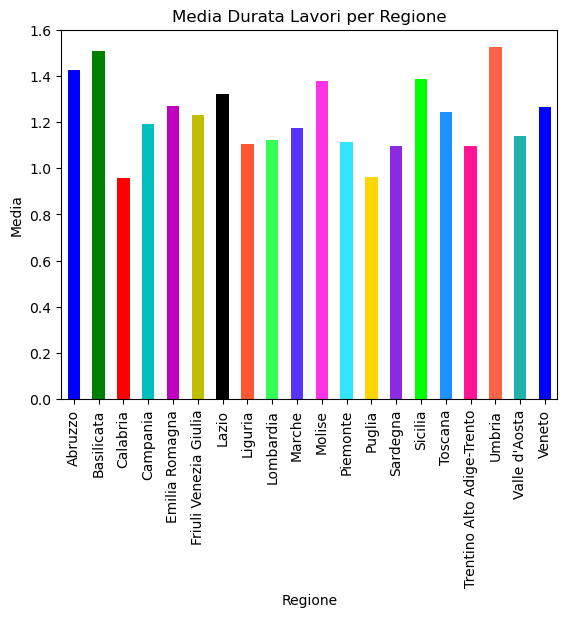

In [34]:
# Raggruppo i dati per regione e calcolo la durata media dei cantieri in ciascuna
# groupby permette di fare aggregazioni per categorie (qui 'Regione')
dfd.groupby(by='Regione')['Durata'].mean().plot(
    kind='bar',  # tipo di grafico a barre
    color = [
        'b', 'g', 'r', 'c', 'm', 'y', 'k',
        '#FF5733', '#33FF57', '#5733FF', '#FF33E6', '#33E6FF',
        '#FFD700', '#8A2BE2', '#00FF00', '#1E90FF', '#FF1493',
        '#FF6347', '#20B2AA'
    ]  # uso diversi colori per rendere le barre più leggibili
)

# Etichette asse X e Y
plt.xlabel('Regione')
plt.ylabel('Media')

# Titolo del grafico
plt.title('Media Durata Lavori per Regione')

# Mostro il grafico
plt.show()


In [35]:
# Calcolo la media e la mediana della durata dei cantieri su tutto il dataset
media_gen = dfd['Durata'].mean()      # Media aritmetica
mediana_gen = dfd['Durata'].median()  # Mediana (valore centrale)

# Confronto media e mediana per capire la forma della distribuzione
if(media_gen > mediana_gen):
    skew = 'positivo'  # distribuzione asimmetrica a destra
else:
    skew = 'negativo'  # distribuzione asimmetrica a sinistra

# Stampo i valori e il tipo di skew
print(f"Media: {media_gen}, Mediana: {mediana_gen}, Skew: {skew}")


Media: 1.1935809360240448, Mediana: 1.0, Skew: positivo


In [36]:
# Calcolo il coefficiente di asimmetria (skewness) della colonna 'Durata'
# Questo valore quantifica quanto la distribuzione è asimmetrica rispetto alla media
dfd['Durata'].skew()

np.float64(1.5527372279745464)

In [37]:
# Statistiche descrittive della colonna 'Durata' e delle altre numeriche del DataFrame
# include: count (numero di valori), mean (media), std (deviazione standard), min, max, quartili (25%, 50%, 75%)
dfd.describe()

,Fibra,FWA,Piano fibra (anno),Piano FWA (anno),Fine Lavori,Durata
count,4658.0,4658.000000,4658.000000,4658.000000,4658.000000,4658.000000
mean,1.0,0.954058,2021.077072,1928.469944,2022.011808,1.193581
std,0.0,0.209383,1.022123,423.233618,0.999716,0.749707
min,1.0,0.000000,2019.000000,0.000000,2019.000000,0.400000
25%,1.0,1.000000,2020.000000,2020.000000,2021.000000,0.700000
50%,1.0,1.000000,2021.000000,2022.000000,2022.000000,1.000000
75%,1.0,1.000000,2022.000000,2022.000000,2023.000000,2.000000
max,1.0,1.000000,2023.000000,2022.000000,2023.000000,4.000000


Qui ecco i dati generali con delle aggiunte, in particolare ci interessano le colonne Piano fibra (anno), Fine lavori e Durata.

Per le colonne 'Fibra' e 'FWA' (che sono dati 1 o 0), possiamo verificare, tramite la riga della media mean, che la Fibra (1.0 di media), ha solo valori 1, quindi come vogliamo noi, e FWA (0.96 di media) anche valori 0, cosa che però non ci interessa dato che l'interesse è solo per la fibra.

In [38]:
# Conta il numero di occorrenze di ciascun valore nella colonna 'Durata'
# Utile per capire quali durate dei cantieri sono più frequenti
dfd['Durata'].value_counts()

Durata
1.0    1590
2.0     866
0.4     343
0.6     326
0.5     316
0.8     313
0.7     301
0.9     282
3.0     252
4.0      69
Name: count, dtype: int64

Possiamo notare che 1.0 anno è la durata con più occorrenze.

Nella Sezione 'Analisi di una Regione Specifica' ho visionato la Lombardia. 
Vediamo la durata dei lavori in Lombardia.

In [39]:
# Conta il numero di occorrenze della durata dei cantieri solo per la regione Lombardia
# Questo permette di analizzare specificamente come si distribuiscono le durate in Lombardia
dfd[dfd['Regione'] == 'Lombardia']['Durata'].value_counts()


Durata
1.0    243
2.0    128
0.7     58
0.6     57
0.4     56
0.5     54
0.9     54
0.8     49
3.0     28
4.0      7
Name: count, dtype: int64

Confrontando i due output delle celle, possiamo notare che i dati sono abbastanza proporzionali, questo è dovuto dal random randint.

Ora vediamo la Durata media divisi per piano d'anno.

<Axes: xlabel='Piano fibra (anno)'>

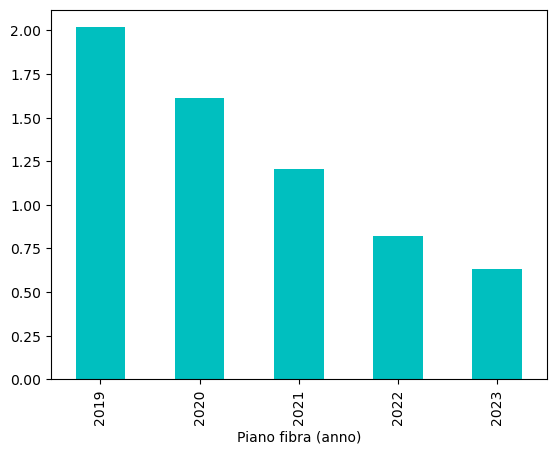

In [40]:
# Raggruppa i cantieri per anno di piano fibra e calcola la durata media per ciascun anno
# Poi visualizza i risultati con un grafico a barre
dfd.groupby(by='Piano fibra (anno)')['Durata'].mean().plot(kind='bar', color='c')


Notiamo che il 2019 è quello con la durata dei lavori più lunga. Una cosa normale visto che quando ho creato la colonna Fine Lavori l'estremo maggiore del range dei numeri random diminuiva con l'avanzare del for, come possiamo vedere anche in questo grafico.

# Query Aggiuntive

- In questo caso prendo il DataFrame dei comuni italiani, per vedere le città dove i lavori della FWA sono in esecuzione o dove è attiva la FWA.

In [41]:
#Modifico il DF
# Creiamo una copia del DataFrame dei comuni italiani per aggiungere informazioni sullo stato dei lavori FWA
df_geo_2 = df_geo.copy()

# Creiamo una condizione per le città dove la FWA è in esecuzione
condizione_esec = df_geo_2['comune'].isin(df.loc[df['Stato FWA'] == 'in esecuzione','Citta'])
df_geo_2.loc[condizione_esec,'Stato'] = 'In esecuzione'

# Creiamo una condizione per le città dove la FWA è terminata o attiva
condizione_term = df_geo_2['comune'].isin(df.loc[df['Stato FWA'] == 'terminato','Citta'])
df_geo_2.loc[condizione_term,'Stato'] = 'In funzione'


Modifico il DataFrame copiato, aggiugendo una colonna 'Stato', che aggiunge una specifica per ogni comune. Specifica che è presa secondo un criterio grazie al DataFrame principale. 

In [42]:
# Manteniamo solo i comuni per cui abbiamo definito uno stato dei lavori FWA
df_geo_2 = df_geo_2.dropna(subset=['Stato'])

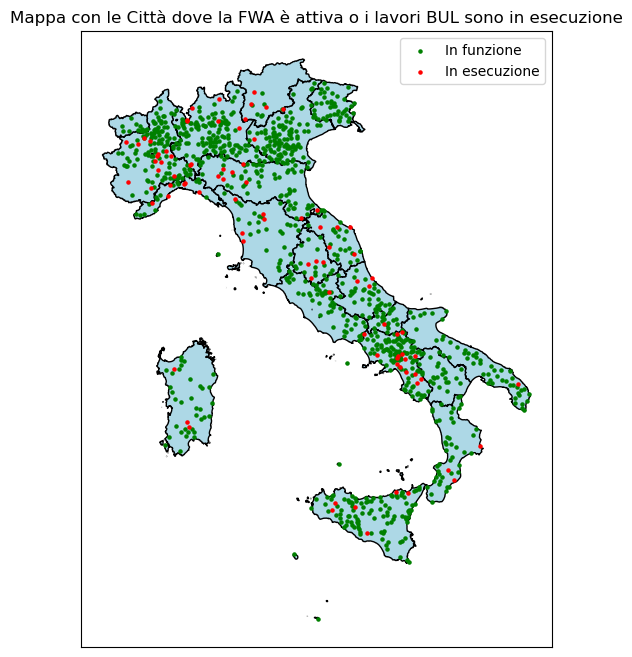

In [43]:

# Creo la geometria (punti) a partire da longitudine e latitudine
geometry = gpd.points_from_xy(df_geo_2['lng'], df_geo_2['lat'])

# Creo un GeoDataFrame con i punti di interesse e assegno il sistema di riferimento geografico
gdf_punti_interesse = gpd.GeoDataFrame(df_geo_2, geometry=geometry, crs=crs_italy)

# Carico i confini delle regioni italiane da un file GeoJSON
italian_regions = gpd.read_file(url_italy)

# Disegno la mappa dell’Italia con le regioni
ax = italian_regions.plot(figsize=(10, 8), color='lightblue', edgecolor='black')

# Filtro i comuni dove la FWA è in funzione
gdf_in_funzione = gdf_punti_interesse[gdf_punti_interesse['Stato'] == 'In funzione']

# Filtro i comuni dove la FWA è in esecuzione
gdf_in_esecuzione = gdf_punti_interesse[gdf_punti_interesse['Stato'] == 'In esecuzione']

# Plotto i punti dei comuni in funzione (verde)
gdf_in_funzione.plot(ax=ax, color='green', markersize=5, marker='o', label='In funzione')

# Plotto i punti dei comuni in esecuzione (rosso)
gdf_in_esecuzione.plot(ax=ax, color='red', markersize=5, marker='o', label='In esecuzione')

# Ciclo per aggiungere etichette ai punti (qui lasciate vuote per non appesantire la mappa)
for x, y, label in zip(gdf_punti_interesse.geometry.x, gdf_punti_interesse.geometry.y, gdf_punti_interesse['comune']):
    ax.text(x, y, '', fontsize=8, ha='right')

# Rimuovo i numeri dagli assi x e y (latitudine/longitudine)
ax.set_xticks([])
ax.set_yticks([])

# Titolo e legenda della mappa
plt.title('Mappa con le Città dove la FWA è attiva o i lavori BUL sono in esecuzione')
plt.legend()
plt.show()



Dalla mappa possiamo notare come la maggior parte dei lavori conclusi è al Nord o segue comunque la catena Appenninica. Questo ci può far capire che le montagne o colline possono essere 'superate' facilmente grazie alla rete Wireless della FWA.

- Nella prima sezione di 'Analisi Generale' avevamo visto un grafico a torta che rappresentava in Italia quali città avevano la Fibra e FWA. Andiamo a visionare le città senza nulla.

In [44]:
# Creo una copia del dataset geografico dei comuni
df_geo_na = df_geo.copy()

# Filtro i comuni che compaiono nel dataset principale con Fibra=0 e FWA=0
# cioè i comuni dove non sono previsti lavori BUL
df_geo_na_filter = df_geo['comune'].isin(
    df[(df['Fibra'] == 0) & (df['FWA'] == 0)]['Citta'].unique()
)

# Applico il filtro al dataframe dei comuni
df_geo_na = df_geo_na[df_geo_na_filter]

# Conteggio dei record rimasti
df_geo_na.count()  


istat     253
comune    253
lng       253
lat       253
dtype: int64

In [45]:
# Crea la mappa centrata sulla media delle coordinate lat/lng dei comuni filtrati
mappa_na = folium.Map(
    location=[df_geo_na['lat'].mean(), df_geo_na['lng'].mean()],
    zoom_start=7
)

# Cicla su tutti i comuni filtrati e aggiunge un marker blu
for index, row in df_geo_na.iterrows():
    folium.CircleMarker(
        location=[row['lat'], row['lng']],   # coordinate
        radius=3,                            # dimensione cerchio
        color='blue',                        # bordo blu
        fill=True,
        fill_color='blue',                   # riempimento blu
        fill_opacity=0.6,                    # trasparenza
        popup=f"Comune: {row['comune']}"     # testo mostrato al click
    ).add_to(mappa_na)

# Mostra la mappa (o eventualmente salva in HTML)
#mappa_na.save('mappa_interattiva_scatter2.html')
display(mappa_na)


- Ora vediamo sempre grazie ad una mappa interrativa le città non coinvolte dal BUL.

In [46]:
# Copia del dataset dei comuni italiani
df_geo_citta_notin = df_geo.copy()

# Condizione: comuni che NON sono presenti tra quelli nel df principale
df_geo_citta_notin_filter = ~df_geo['comune'].isin(df['Citta'].unique())

# Applica il filtro
df_geo_citta_notin = df_geo_citta_notin[df_geo_citta_notin_filter]

# Conta quanti comuni rimangono
df_geo_citta_notin.count()


istat     538
comune    538
lng       538
lat       538
dtype: int64

In [47]:
# Creiamo una mappa Folium centrata sulla media delle coordinate dei comuni NON presenti nel dataset principale
mappa_notin = folium.Map(location=[df_geo_citta_notin['lat'].mean(), df_geo_citta_notin['lng'].mean()], zoom_start=7)

# Cicliamo ogni riga del dataframe filtrato (df_geo_citta_notin)
# e aggiungiamo un marker (cerchietto) per rappresentare ogni comune
for index, row in df_geo_citta_notin.iterrows():
    folium.CircleMarker(
        location=[row['lat'], row['lng']],  # coordinate del comune
        radius=3,                           # raggio del cerchio
        color='blue',                       # colore del bordo
        fill=True,                          # riempiamo il cerchio
        fill_color='blue',                  # colore del riempimento
        fill_opacity=0.6,                   # trasparenza del riempimento
        popup=f"Comune: {row['comune']}"    # testo che appare cliccando sul cerchio
    ).add_to(mappa_notin)


# Visualizziamo la mappa direttamente nel notebook
display(mappa_notin)


Notiamo grande prevalenza nella zona Alto Adige e nell'Abbruzzo.

# Sitografia
- Progetto BUL e DataFrame Principale: https://bandaultralarga.italia.it/
- DataFrame Comuni Italiani: https://github.com/MatteoHenryChinaski/Comuni-Italiani-2018-Sql-Json-excel
- DataFram PCN: https://www.infratelitalia.it/-/media/infratel/documents/elenco-dei-pcn-consegnati-da-open-fiber.xlsx?la=it-it&hash=6D6523EA24A46D18E01BB94C8F02AC6B2017C2A6